# Importing required Packages

In [31]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
import nltk
from sklearn.neighbors import KNeighborsClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import time
from nltk.stem import WordNetLemmatizer

# Data Cleaning

In [32]:
org_df = pd.read_csv('train_2.csv', low_memory=False)

In [33]:
org_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [34]:
train_df = pd.read_csv('train_2.csv', usecols=['text', 'sentiment', 'Age of User'], low_memory=False)

In [35]:
train_df.shape

(27481, 3)

In [36]:
test_df = pd.read_csv('test_2.csv', usecols=['text', 'sentiment', 'Age of User'], low_memory=False)

Merged train and test df

In [37]:
df = pd.concat([train_df, test_df], ignore_index=True)

In [38]:
null_counts = df.isnull().sum()
print(null_counts)

text           1
sentiment      0
Age of User    0
dtype: int64


In [39]:
df = df.dropna()

In [40]:
dup_rows = df.duplicated().sum()
print(f"dup rows: {dup_rows}")

dup rows: 5


In [41]:
df = df.drop_duplicates()

Label Encoding

In [42]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

Converted age to continous values

In [43]:
df['Age of User'] = df['Age of User'].map({
    '0-20': 1, 
    '21-30': 2, 
    '31-45': 3, 
    '46-60': 4, 
    '60-70': 5, 
    '70-100': 6
})

In [84]:
df.head(10)

,text,sentiment,Age of User
0,respond go,1,1
1,sooo sad miss san diego,0,2
2,boss bulli,0,3
3,interview leav alon,0,4
4,son put releas alreadi bought,0,5
5,shameless plug best ranger forum earth,1,6
6,2am feed babi fun smile coo,2,1
7,soooo high,1,2
8,,1,3
9,journey wow u becam cooler hehe possibl,2,4


# EDA

EDA 1: HeatMap <br>
To check the co-relation between "Sentiment (target)" and "Age of user" columns.

In [45]:
heat_map = df[['sentiment','Age of User']]

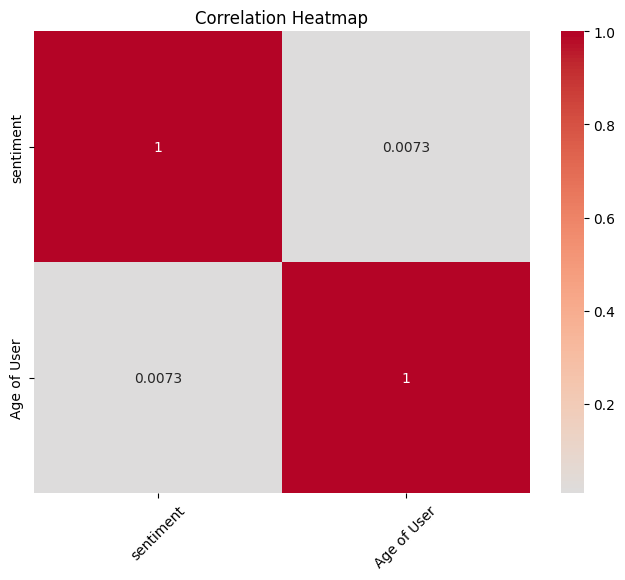

In [46]:
correlation_matrix = heat_map.corr().round(4)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.show()

EDA 2: Wordcloud <br>
To display most repeated words in text columns.

In [47]:
nltk.download('stopwords', quiet=True)

True

In [48]:
from wordcloud import WordCloud

def top_word_WC(df):
    text = ' '.join(df['text'].astype(str))
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word not in stop_words]
    
    word_freq = Counter(words)
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white', 
                          max_words=100).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words')
    plt.show()

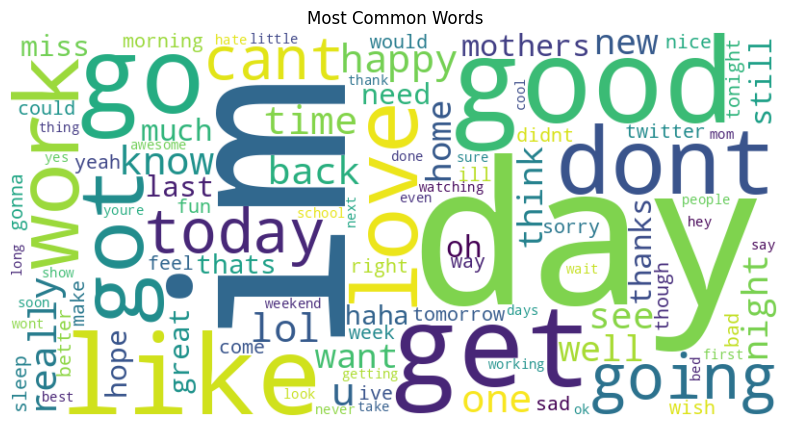

In [49]:
top_word_WC(df)

EDA 3: Bar graph of Most repeated words

In [50]:
import matplotlib.cm as cm

def bar_graph(df, top_n=20):
    text = ' '.join(df['text'].astype(str))
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word not in stop_words]
    word_freq = Counter(words)
    top_words = word_freq.most_common(top_n)
    words, frequencies = zip(*top_words)
    
    plt.figure(figsize=(8, 6))
    plt.bar(words, frequencies)
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

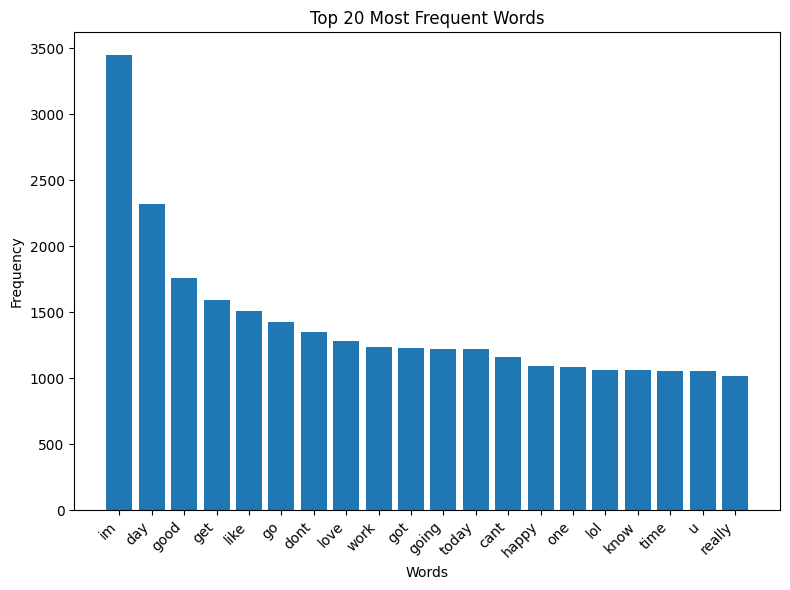

In [51]:
bar_graph(df)

# Preprocessing

Preprocessing 1: Lower Case

In [52]:
df['text'] = df['text'].str.lower()

Preprocessing 2: De-contractions Words

In [53]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [54]:
def contr_words(text, contractions_dict):
    text = str(text)
    for contraction, expansion in contractions_dict.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text, flags=re.IGNORECASE)
    return text

df['text'] = df['text'].apply(lambda x: contr_words(x, contractions))

Preprocessing 3: Removing links

In [55]:
df['text'] = df['text'].str.replace(r'http\S+|www\.\S+', ' ', regex=True)

Preprocessing 4: Removing Stopwords

In [56]:
nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
def remove_stopwords(text):
    tokens = word_tokenize(text.lower())  
    tokens_wo_stopwords = [word for word in tokens if word not in english_stopwords] 
    return ' '.join(tokens_wo_stopwords)

df['text'] = df['text'].apply(remove_stopwords)

Preprocessin 5: Removing HTML

In [58]:
df['text'] = df['text'].str.replace(r'<[^>]+>', ' ', regex=True)

Preprocessing 6: Removing Special Characters

In [59]:
df['text'] = df['text'].str.replace(r'[^a-zA-Z0-9\s]', ' ', regex=True)

Preprocessing 7: Removing Punctuation

In [60]:
df['text'] = df['text'].str.replace(r'[^\w\s]', ' ', regex=True)

Preprocessing 8: Removing Extra Spaces

In [61]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)

Preprocessing 9: Stemming

In [62]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [63]:
ps = PorterStemmer()

def stem_text(text):
    words = str(text).lower().split()
    stemmed_words = [ps.stem(word) for word in words]
    return ' '.join(stemmed_words)

df['text'] = df['text'].apply(stem_text)

# Bag of Words

Using sklearn-TfidfVectorizer 

In [64]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=10000,
    lowercase=True,
)
bow_matrix = vectorizer.fit_transform(df['text'])
feature_names = vectorizer.get_feature_names_out()

In [65]:
print(len(feature_names))

10000


Converting Bag of words matrix to dataframe.

In [66]:
bow_matrix_df = pd.DataFrame(bow_matrix.toarray())

In [67]:
bow_matrix_df = bow_matrix_df.reset_index(drop=True)

In [68]:
bow_matrix_df.shape

(31009, 10000)

# Train, Test, Split

In [69]:
X = bow_matrix_df
y = df['sentiment']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Model 1: Random Forest

In [71]:
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42
)
start_time = time.time()
rf_classifier.fit(X_train, y_train)
rf_training_time = time.time() - start_time
rf_pred = rf_classifier.predict(X_test)

In [72]:
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("RF Training Time: {:.4f} seconds".format(rf_training_time))

Accuracy: 0.7200902934537246
RF Training Time: 131.4902 seconds


# Model 2: Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(
    max_iter=1000,
    random_state=42
)

start_time = time.time()
lr_classifier.fit(X_train, y_train)
lr_training_time = time.time() - start_time
lr_pred = lr_classifier.predict(X_test)

In [76]:
print("Accuracy:", accuracy_score(y_test, lr_pred))
print("LR Training Time: {:.4f} seconds".format(lr_training_time))

Accuracy: 0.7004192196065785
LR Training Time: 251.0860 seconds


# Extracting Models

In [77]:
import joblib

joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
joblib.dump(rf_classifier, 'random_forest_model.joblib')
joblib.dump(lr_classifier, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

In [78]:
def preprocess_text(text):
    text = text.lower()
    
    contractions = { 
        "ain't": "am not", 
        "aren't": "are not", 
        "can't": "cannot"
    }
    for contraction, expansion in contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text, flags=re.IGNORECASE)
    
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    stopwords_set = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens_wo_stopwords = [word for word in tokens if word not in stopwords_set]

    tokens_wo_stopwords = [re.sub(r'[^a-zA-Z]', '', word) for word in tokens_wo_stopwords]
    tokens_wo_stopwords = [word for word in tokens_wo_stopwords if word]
    
    ps = PorterStemmer()
    stemmed_tokens = [ps.stem(word) for word in tokens_wo_stopwords]
    
    return ' '.join(stemmed_tokens)

In [87]:
def predict_sentiment(text):
    vectorizer = joblib.load('tfidf_vectorizer.joblib')
    rf_model = joblib.load('random_forest_model.joblib')
    processed_text = preprocess_text(text)
    text_vectorized = vectorizer.transform([processed_text])
    prediction = rf_model.predict(text_vectorized)[0]
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_map[prediction]

In [90]:
result = predict_sentiment("This is a great product!")
print(result)

Positive
